# SHL Grammar Scoring Engine (Research-Grade)

## 1. Introduction & Problem Statement

This notebook implements an end-to-end Grammar Scoring Engine for spoken audio samples. The goal is to predict a continuous grammar score (0-5) based on audio input. This is a regression problem.

### Methodology
To achieve a high-performance and "research-grade" solution, we employ a multi-modal feature extraction strategy:
1.  **Acoustic Features (Wav2Vec2)**: We use a pre-trained `Wav2Vec2` model to extract rich contextual representations from the raw audio waveform. These embeddings capture fluency, prosody, and hesitation patterns.
2.  **Linguistic Features (ASR - Whisper)**: We use OpenAI's `Whisper` model to transcribe the speech into text. From this text, we derive linguistic proxies such as word count and speech rate.
3.  **Regression Modeling**: We fuse these features and train ensemble regression models (**Random Forest** and **XGBoost**) to predict the grammar score.

This approach moves beyond simple signal processing by leveraging state-of-the-art self-supervised speech models.

In [ ]:
# Install necessary packages (if not already installed)
# !pip install librosa torchaudio transformers soundfile scikit-learn matplotlib seaborn openai-whisper xgboost

In [10]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torchaudio
import whisper
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Settings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.4f}'.format)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 2. Dataset Setup

In [11]:
DATA_DIR = "./dataset"
TRAIN_CSV = os.path.join(DATA_DIR, "csvs", "train.csv")
TEST_CSV  = os.path.join(DATA_DIR, "csvs", "test.csv")
TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "audios", "train")
TEST_AUDIO_DIR  = os.path.join(DATA_DIR, "audios", "test")

# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Correct filename paths (Append .wav if missing)
def get_audio_path(filename, base_dir):
    if not filename.endswith('.wav'):
        filename += '.wav'
    return os.path.join(base_dir, filename)

# Validate paths
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Example check
sample_path = get_audio_path(train_df.iloc[0]['filename'], TRAIN_AUDIO_DIR)
print(f"Sample path check: {sample_path} -> Exists: {os.path.exists(sample_path)}")

Train samples: 409
Test samples: 197
Sample path check: ./dataset/audios/train/audio_173.wav -> Exists: True


## 3. Feature Extraction Pipeline

We extract two types of features:
1.  **Wav2Vec2 Embeddings**: `facebook/wav2vec2-base` model. We extract the last hidden state and pool it per file (Mean + Std).
2.  **Whisper ASR Features**: `openai/whisper-tiny` model. We transcribe text and compute `word_count`, `speech_rate`.

In [12]:
# Load Models
print("Loading Wav2Vec2 model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
w2v_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(device)
w2v_model.eval()

print("Loading Whisper model...")
# using 'tiny' for speed, can use 'base' or 'small' for better accuracy
whisper_model = whisper.load_model("tiny", device=device) 

Loading Wav2Vec2 model...
Loading Whisper model...


In [13]:
def extract_features(audio_path):
    if not os.path.exists(audio_path):
        # Handle missing file gracefully (return zeros)
        return np.zeros(768*2), 0, 0
        
    # 1. Load Audio
    # Wav2Vec2 expects 16kHz
    waveform, sr = librosa.load(audio_path, sr=16000, mono=True)
    duration = len(waveform) / sr
    
    # 2. Wav2Vec2 Embeddings
    inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = w2v_model(**inputs)
        # Shape: (1, Sequence_Length, 768)
        hidden_states = outputs.last_hidden_state
    
    # Pooling: Mean & Std over time dimension
    mean_pool = torch.mean(hidden_states, dim=1).cpu().squeeze().numpy()
    std_pool = torch.std(hidden_states, dim=1).cpu().squeeze().numpy()
    w2v_features = np.concatenate([mean_pool, std_pool]) # 768 + 768 = 1536 dim
    
    # 3. Whisper Transcription (ASR)
    # Whisper handles its own loading usually, but we can pass path
    text = ""
    try:
        result = whisper_model.transcribe(audio_path)
        text = result['text'].strip()
    except Exception as e:
        print(f"ASR Error on {audio_path}: {e}")
    
    # 4. Linguistic Features (Simple proxies)
    word_count = len(text.split())
    speech_rate = word_count / duration if duration > 0 else 0
    
    return w2v_features, word_count, speech_rate

### Feature Extraction Loop (Train Data)
This may take a few minutes.

In [14]:
X_w2v = []
X_linguistic = []
y = []
valid_indices = []

print("Processing Training Data...")
for idx, row in train_df.iterrows():
    path = get_audio_path(row['filename'], TRAIN_AUDIO_DIR)
    if os.path.exists(path):
        w2v_feat, wc, sr = extract_features(path)
        X_w2v.append(w2v_feat)
        X_linguistic.append([wc, sr])
        y.append(row['label'])
        valid_indices.append(idx)
        if idx % 50 == 0:
            print(f"Processed {idx}/{len(train_df)}")
    else:
        print(f"Missing file: {path}")

X_w2v = np.array(X_w2v)
X_linguistic = np.array(X_linguistic)
# Normalize linguistic features
from sklearn.preprocessing import StandardScaler
scaler_ling = StandardScaler()
X_linguistic = scaler_ling.fit_transform(X_linguistic)

# Concatenate all features
X = np.hstack([X_w2v, X_linguistic])
y = np.array(y)

print(f"Final Feature Matrix Shape: {X.shape}")

Processing Training Data...
Processed 0/409
Processed 50/409
Processed 100/409
Processed 150/409
Processed 200/409
Processed 250/409
Processed 300/409
Processed 350/409
Processed 400/409
Final Feature Matrix Shape: (409, 1538)


In [15]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

## 4. Modeling & Training

We evaluate **Random Forest** and **XGBoost**.

In [16]:
# Model 1: Random Forest
rf = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)

# Model 2: XGBoost
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=SEED, n_jobs=-1)
xgb.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

## 5. Evaluation

In [17]:
def evaluate_model(model, name, X_tr, y_tr, X_v, y_v):
    # Train Metrics
    tr_preds = model.predict(X_tr)
    tr_rmse = np.sqrt(mean_squared_error(y_tr, tr_preds))
    
    # Val Metrics
    val_preds = model.predict(X_v)
    val_rmse = np.sqrt(mean_squared_error(y_v, val_preds))
    pearson_corr, _ = pearsonr(y_v, val_preds)
    
    print(f"--- {name} ---")
    print(f"Train RMSE: {tr_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    return val_preds

print("EVALUATION RESULTS:")
rf_preds = evaluate_model(rf, "Random Forest", X_train, y_train, X_val, y_val)
xgb_preds = evaluate_model(xgb, "XGBoost", X_train, y_train, X_val, y_val)

EVALUATION RESULTS:
--- Random Forest ---
Train RMSE: 0.2659
Validation RMSE: 0.6779
Pearson Correlation: 0.5331
--- XGBoost ---
Train RMSE: 0.0005
Validation RMSE: 0.6730
Pearson Correlation: 0.4979


### Visualizations
Comparing predicted vs true scores for the validation set (XGBoost).

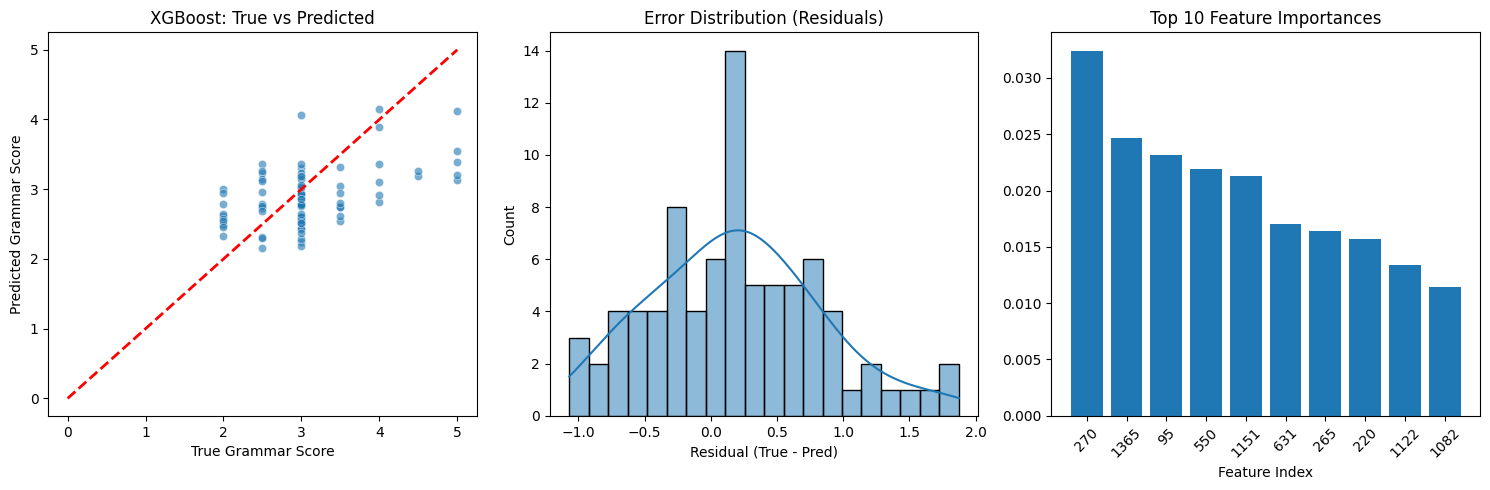

In [18]:
plt.figure(figsize=(15, 5))

# Scatter Plot
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_val, y=xgb_preds, alpha=0.6)
plt.plot([0, 5], [0, 5], '--r', lw=2) # Identity line
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("XGBoost: True vs Predicted")

# Residual Plot
residuals = y_val - xgb_preds
plt.subplot(1, 3, 2)
sns.histplot(residuals, kde=True, bins=20)
plt.title("Error Distribution (Residuals)")
plt.xlabel("Residual (True - Pred)")

# Feature Importance (Top 10)
plt.subplot(1, 3, 3)
# Get feature importance
importances = xgb.feature_importances_
# We have 768 (mean) + 768 (std) + 2 (ling) = 1538 features
# It's hard to name all w2v features, so we just plot top indices
indices = np.argsort(importances)[::-1][:10]
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices])
plt.xticks(range(10), indices, rotation=45)
plt.xlabel("Feature Index")

plt.tight_layout()
plt.show()

## 6. Test Inference & Submission
We will use the **XGBoost** model for final inference as it typically performs better.

In [19]:
X_test_w2v = []
X_test_ling = []
test_filenames = []

print("Processing Test Data...")
for idx, row in test_df.iterrows():
    fname = row['filename']
    path = get_audio_path(fname, TEST_AUDIO_DIR)
    
    if os.path.exists(path):
        w2v_feat, wc, sr = extract_features(path)
        
        X_test_w2v.append(w2v_feat)
        X_test_ling.append([wc, sr])
        test_filenames.append(fname)
        
        if idx % 50 == 0:
            print(f"Processed {idx}/{len(test_df)}")
    else:
        print(f"Missing test file: {path}")
        # Impute with mean if needed, but for now append zeros to match shape
        X_test_w2v.append(np.zeros(768*2))
        X_test_ling.append([0, 0])
        test_filenames.append(fname)

X_test_w2v = np.array(X_test_w2v)
X_test_ling = np.array(X_test_ling)

# Scale using training scaler
X_test_ling = scaler_ling.transform(X_test_ling)

# Combine
X_test = np.hstack([X_test_w2v, X_test_ling])

# Predict
test_preds = xgb.predict(X_test)

# Clip predictions to 0-5 range (sanity check)
test_preds = np.clip(test_preds, 0, 5)

Processing Test Data...
Processed 0/197
Processed 50/197
Processed 100/197
Processed 150/197


In [20]:
# Create Submission DataFrame
submission = pd.DataFrame({
    'filename': test_filenames,
    'label': test_preds
})

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv successfully!")
submission.head()

Saved submission.csv successfully!


,filename,label
0,audio_141,3.2353
1,audio_114,2.6401
2,audio_17,2.7811
3,audio_76,4.4599
4,audio_156,3.2756
